# Seasonality analysis

In [28]:
import os
import datetime as dt


import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL

from IPython.display import display, Markdown

import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter



class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD



# set maximum number of years to analyze
max_num_of_years = 5


def D(text: str):
    display(Markdown(text))






D('## Analysis configuration:')
D(f'* **Symbol selected**: {symbol}')
D(f'* **Max years to analyse**: {dt.date.today().year-1} until earliest {dt.date.today().year-max_num_of_years}')


## Analysis configuration:

* **Symbol selected**: EBAY

* **Max years to analyse**: 2022 until earliest 2018

In [29]:
dirname = '.downloads'
historyFilename = f'{dirname}{os.path.sep}{symbol}_{dt.date.today()}.csv'
cacheFilename = f"{dirname}{os.path.sep}yfinance.cache"

os.makedirs(dirname, exist_ok=True)


session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket),
    backend=SQLiteCache(cacheFilename),
)
ticker = yf.Ticker(symbol, session=session)
df = ticker.history(period='max')

if not os.path.isfile(historyFilename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
    df.to_csv(historyFilename)
else:
    df = pd.read_csv(historyFilename, parse_dates=['Date'], index_col=['Date'])




D('## Data loaded:')
D(f'* Close prices of symbol _{symbol}_')
D(f'* From {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")}')

#for (k, v) in ticker.info.items():
#    D(f'* {k}: {v}')

D('## Statistics:')
print(df.describe())
D('## Data:')
print(df)

## Data loaded:

* Close prices of symbol _EBAY_

* From 24.09.98 to 23.06.23

## Statistics:

             Close
count  6227.000000
mean     22.097673
std      15.986711
min       0.508558
25%      10.000000
50%      16.691919
75%      31.785000
max      80.589996


## Data:

                Close
Date                 
1998-09-24   0.830791
1998-09-25   0.786949
1998-09-28   0.846135
1998-09-29   0.857095
1998-09-30   0.790237
...               ...
2023-06-16  45.060001
2023-06-20  44.840000
2023-06-21  44.099998
2023-06-22  43.869999
2023-06-23  43.369999

[6227 rows x 1 columns]


In [30]:
rolling_resolution = 200

df.index = pd.to_datetime(df.index)
df = df.asfreq('d')                 # set correct frequency
df = df.fillna(method='ffill')      # fill up missing values

annualDf = pd.DataFrame()
numOfYears = 0
for year in sorted(list(set(df.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = df[str(year) + '-01-01':str(year) + '-12-31']['Close'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    annualDf[str(year)] = curYearValues

resultMean = annualDf.mean(axis=1)
resultMin = annualDf.min(axis=1)
resultMax = annualDf.max(axis=1)
annualDf['mean'] = resultMean
annualDf['min'] = resultMin
annualDf['max'] = resultMax

lastYear = dt.date.today().year-1
range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='D')
annualDf['date'] = range
annualDf = annualDf.set_index('date')

# annualDf.index = resultDf.index.strftime('%d. %b')

D('## Initial data overview')
annualDf

## Initial data overview

,2022,2021,2020,2019,2018,mean,min,max
date,,,,,,,,
2022-01-01,66.500000,50.250000,36.110001,28.070000,37.740002,43.734000,28.070000,66.500000
2022-01-02,66.500000,50.250000,36.299999,28.850000,38.060001,43.992000,28.850000,66.500000
2022-01-03,66.800003,50.250000,35.959999,28.320000,39.220001,44.110001,28.320000,66.800003
2022-01-04,65.139999,51.500000,35.959999,28.969999,38.570000,44.027999,28.969999,65.139999
2022-01-05,64.489998,52.029999,35.959999,28.969999,39.689999,44.227999,28.969999,64.489998
...,...,...,...,...,...,...,...,...
2022-12-27,40.080002,65.660004,50.119999,36.070000,28.030001,43.992001,28.030001,65.660004
2022-12-28,39.919998,66.080002,50.240002,36.070000,28.240000,44.110000,28.240000,66.080002
2022-12-29,41.820000,66.459999,50.860001,36.070000,28.240000,44.690000,28.240000,66.459999


In [31]:
decompose = MSTL(df['Close'], periods=365)
decompose = decompose.fit()

numOfYears = 0
for year in sorted(list(set(decompose.seasonal.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = decompose.seasonal[str(year) + '-01-01':str(year) + '-12-31'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    annualDf['seasonal-' + str(year)] = curYearValues


D('## Seasonal decomposition')
annualDf
decompose.seasonal

## Seasonal decomposition

Date
1998-09-24   -0.924087
1998-09-25   -0.952055
1998-09-26   -0.928804
1998-09-27   -1.147379
1998-09-28   -1.326666
                ...   
2023-06-19   -1.995421
2023-06-20   -2.061356
2023-06-21   -2.068103
2023-06-22   -1.689491
2023-06-23   -1.668572
Freq: D, Name: seasonal, Length: 9039, dtype: float64

In [32]:
monthlyDf = pd.DataFrame()
numOfYears = 0
for year in sorted(list(set(decompose.seasonal.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = decompose.seasonal[str(year) + '-01-01':str(year) + '-12-31'].resample('M').mean().values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    monthlyDf['seasonal-' + str(year)] = curYearValues


montlyMean = monthlyDf.mean(axis=1)
monthlyStd = monthlyDf.std(axis=1)
monthlyMax = monthlyDf.max(axis=1)
monthlyDf['mean'] = montlyMean
monthlyDf['std'] = monthlyStd

monthlyDf['meanPositive'] = monthlyDf['mean'] > 0

range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='M')
monthlyDf['date'] = range
monthlyDf = monthlyDf.set_index('date')
monthlyDf.index = monthlyDf.index.strftime('%b')

D('## Monthly mean')
monthlyDf

## Monthly mean

,seasonal-2022,seasonal-2021,seasonal-2020,seasonal-2019,seasonal-2018,mean,std,meanPositive
date,,,,,,,,
Jan,-0.552345,-0.787539,-1.072481,-1.287517,-1.362570,-1.012490,0.340636,False
Feb,0.914945,0.823351,0.671083,0.526180,0.530853,0.693282,0.173818,True
Mar,-2.596902,-2.094601,-1.631743,-1.242169,-0.686132,-1.650309,0.739931,False
Apr,-0.898938,-0.795240,-0.709698,-0.680551,-0.613984,-0.739682,0.110278,False
May,-1.979618,-1.664285,-1.413471,-1.209663,-0.748498,-1.403107,0.465462,False
Jun,-0.197129,0.073142,0.252394,0.374010,0.677532,0.235990,0.327257,True
Jul,2.750225,2.637813,2.465660,2.278385,2.176053,2.461627,0.239519,True
Aug,3.913602,3.451243,2.994975,2.582574,2.217469,3.031973,0.674500,True
Sep,0.895268,1.057790,1.205433,1.465153,1.539528,1.232634,0.270821,True


<Axes: title={'center': 'Monthly mean performance'}, xlabel='date'>

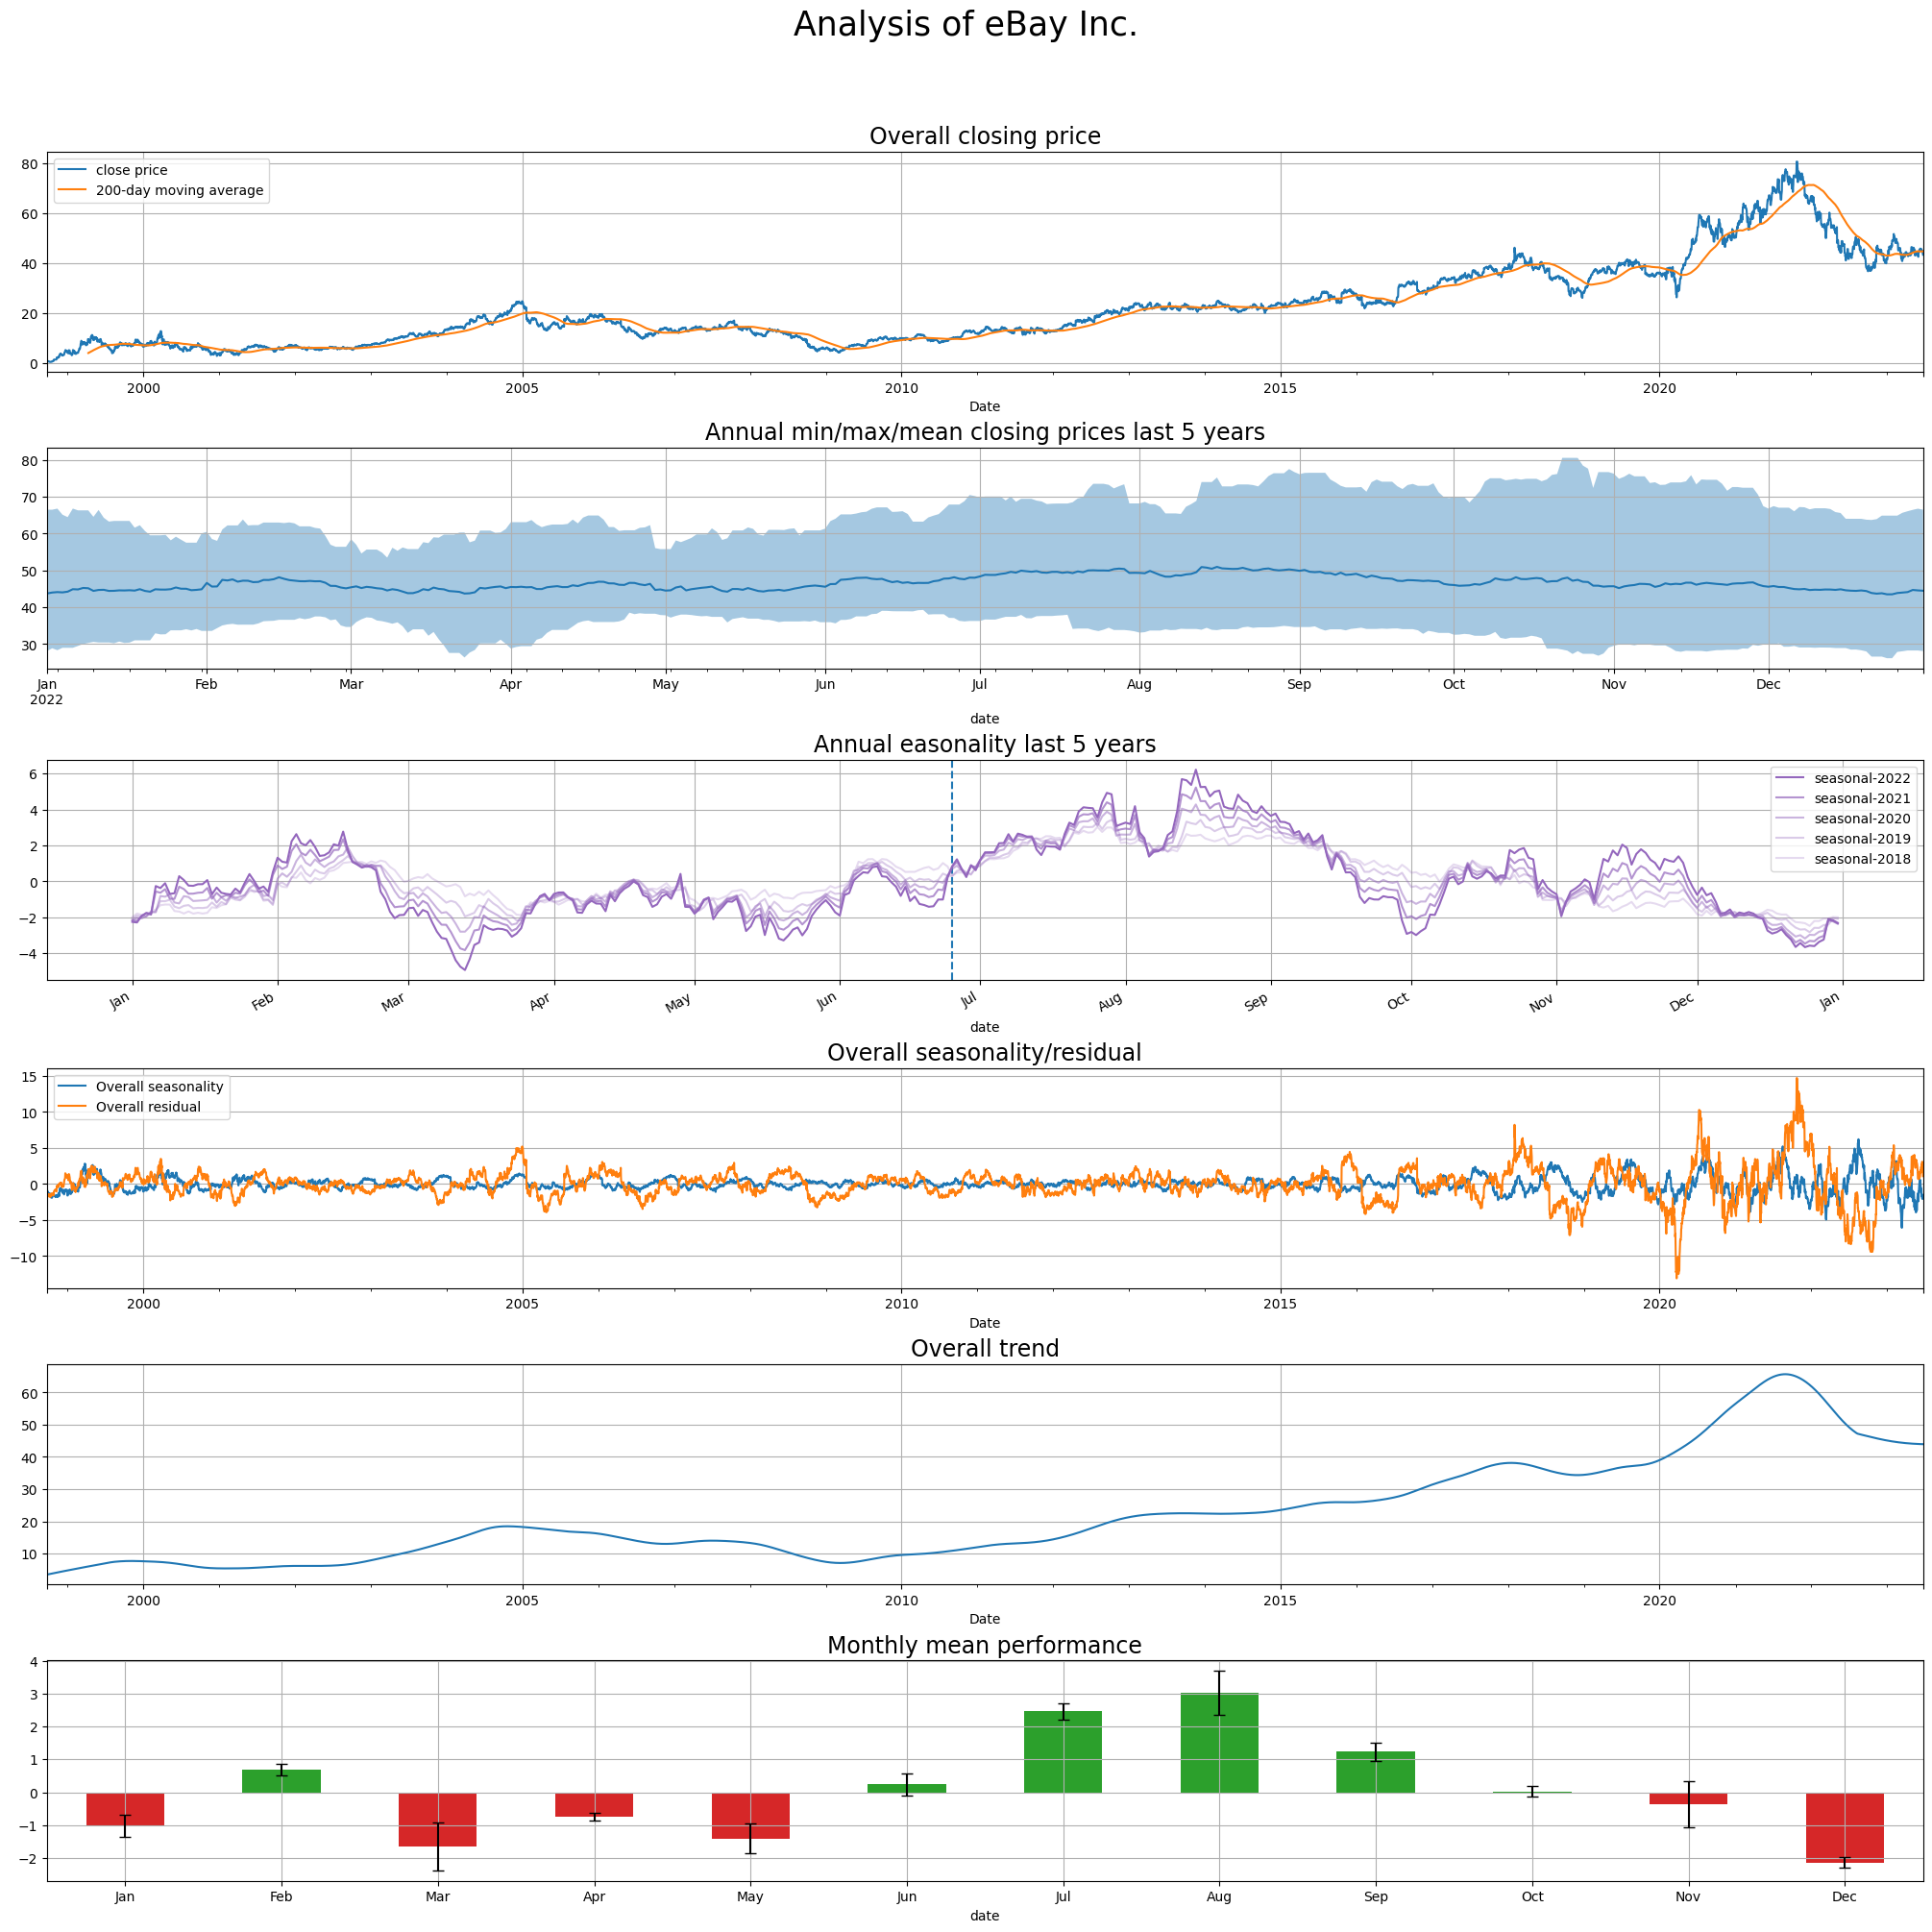

In [37]:
plt.figure(figsize=(20, 20), layout='constrained')
plt.suptitle(f'Analysis of {ticker.info["longName"]}\n\n', fontsize=25)

plt.subplot(611)
plt.title('Overall closing price', fontsize=17)
df['Close'].plot(legend=True, label='close price')
df['Close'].rolling(rolling_resolution).mean().plot(legend=True, label=str(rolling_resolution) + '-day moving average', grid=True)

plt.subplot(612)
plt.title(f'Annual min/max/mean closing prices last {max_num_of_years} years', fontsize=17)
plt.fill_between(annualDf.index, annualDf['min'], annualDf['max'], alpha=0.4)
annualDf['mean'].plot(grid=True)

plt.subplot(613)
plt.title(f'Annual easonality last {max_num_of_years} years', fontsize=17)
plt.axvline(mdates.date2num(dt.datetime(lastYear, dt.date.today().month, dt.date.today().day)), linestyle='dashed')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
alpha_value = 1
for col in annualDf.columns:
    if col.startswith('seasonal-'):
        annualDf[col].plot(legend=True, color='tab:purple', alpha=alpha_value, grid=True)
        alpha_value = alpha_value * 0.7

plt.subplot(614)
plt.title('Overall seasonality/residual', fontsize=17)
decompose.seasonal.plot(legend=True, label='Overall seasonality', grid=True)
decompose.resid.plot(legend=True, label='Overall residual', grid=True)

plt.subplot(615)
plt.title('Overall trend', fontsize=17)
decompose.trend.plot(grid=True)

plt.subplot(616)
plt.title('Monthly mean performance', fontsize=17)
monthlyDf['mean'].plot(kind='bar', yerr=monthlyDf['std'], capsize=4, color=monthlyDf['meanPositive'].map({True: 'tab:green', False: 'tab:red'}), grid=True, rot=0)